# Lasso regression for time series example

This notebooks provides an example on how to create a linear model (Lasso) with SAM.

The timeseries model utilizes the feature engineering capabilities of SAM. To learn more about feature engineering, see the notebook `feature_engineering.ipynb` and the [Feature Engineering](https://sam.nist.gov/docs/feature-engineering) section of the SAM documentation.

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2


In [2]:
from sam.models import LassoTimeseriesRegressor
from sam.feature_engineering import SimpleFeatureEngineer

import pandas as pd

2022-08-02 16:48:35.770817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 16:48:35.770869: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
data = pd.read_parquet("../data/rainbow_beach.parquet")
data.head()

,batttery_life,transducer_depth,turbidity,water_temperature,wave_height,wave_period
TIME,,,,,,
2014-06-15 00:00:00,11.6,1.495,0.85,16.6,0.136,3.0
2014-06-15 01:00:00,11.6,1.420,0.87,16.3,0.117,4.0
2014-06-15 02:00:00,11.6,1.478,0.79,16.1,0.114,7.0
2014-06-15 03:00:00,11.6,1.518,0.76,15.9,0.111,3.0
2014-06-15 04:00:00,11.6,1.507,0.77,15.7,0.107,3.0


To use the model, we need a feature engineering transformer. `sam.feature_engineering` contains a number of transformers that can be used to create features from the data, suitable for time series problems.

In [4]:
simple_features = SimpleFeatureEngineer(
    rolling_features=[
        ("wave_height", "mean", 48),
        ("wave_height", "mean", 24),
        ("wave_height", "mean", 12),
        ("wave_height", "mean", 6),
        ("wave_height", "mean", 3),
    ],
    time_features=[
        ("hour_of_day", "onehot"),
        ("day_of_week", "onehot"),
    ],
    keep_original=False,
)

X = data
y = data["water_temperature"]


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# for now LassoTimeseriesRegressor does not support predicting for missing data, so we include
# a SimpleImputer after feature engineering.
feature_pipeline = Pipeline(
    steps=[
        ("features", simple_features),
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)


The following example creates a model for nowcasting (predicting the current value of a certain variable).

In [5]:
model = LassoTimeseriesRegressor(
    predict_ahead=(0,),
    quantiles=(0.1, 0.9),
    alpha=1e-4,
    average_type="median",
    feature_engineer=feature_pipeline,
)

model.fit(X, y)

LassoTimeseriesRegressor(alpha=0.0001, average_type='median',
                         feature_engineer=Pipeline(steps=[('features',
                                                           SimpleFeatureEngineer(rolling_features=[('wave_height',
                                                                                                    'mean',
                                                                                                    48),
                                                                                                   ('wave_height',
                                                                                                    'mean',
                                                                                                    24),
                                                                                                   ('wave_height',
                                                                                                    'mean',
                                                                                                    12),
                                                                                                   ('wave_height',
                                                                                                    'mean',
                                                                                                    6),
                                                                                                   ('wave_height',
                                                                                                    'mean',
                                                                                                    3)],
                                                                                 time_features=[('hour_of_day',
                                                                                                 'onehot'),
                                                                                                ('day_of_week',
                                                                                                 'onehot')])),
                                                          ('imputer',
                                                           SimpleImputer()),
                                                          ('scaler',
                                                           StandardScaler())]),
                         quantiles=(0.1, 0.9))

<AxesSubplot:xlabel='TIME'>

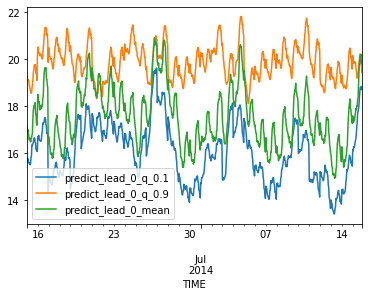

In [6]:
pred = model.predict(X, force_monotonic_quantiles=True)

pred.plot()

In [7]:
model.score(X, y)

3.1206346375258462

To create a forecasting model, one can choose `predict_ahead` differently. Choose a tuple of multiple values to predict multiple timesteps ahead. Also, the parameter `use_diff_of_y` can be useful in forecasting applications.